In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import imageio
from scipy.optimize import minimize
from scipy.fft import fft, fftfreq
import scipy.signal as signal
from functools import partial
from pathlib import Path

In [2]:
from scipy.signal import spectrogram

In [3]:
sys.path.append("../scripts")

In [4]:
from preprocess import (
    ADC_convert,
    mask_hot_dead,
    apply_linear_corr,
    clean_dark,
    get_cds,
    bin_obs,
    correct_flat_field,
)

In [5]:
pd.set_option("display.float_format", "{:.5f}".format)

In [6]:
data_dir = "../data/raw"
train_gt = pd.read_csv(Path(data_dir) / "train_labels.csv")
train_adc = pd.read_csv(Path(data_dir) / "train_adc_info.csv")
axis_df = pd.read_parquet(Path(data_dir) / "axis_info.parquet")
waves_df = pd.read_csv(Path(data_dir) / "wavelengths.csv")

In [7]:
sample_sub = pd.read_csv(Path(data_dir) / "sample_submission.csv")

Time axis analysis


In [8]:
# the time axis is correlated. They are just measuring it at different frequency (11250 AIRS measurements vs 135000 FGS1 measurements over the same period)
np.corrcoef(axis_df["AIRS-CH0-axis0-h"][:11250], axis_df["FGS1-axis0-h"][:11250])

array([[1., 1.],
       [1., 1.]])

In [9]:
# Time gap between observations
print(
    (
        axis_df["AIRS-CH0-axis0-h"][2:11250:2].values
        - axis_df["AIRS-CH0-axis0-h"][1:11249:2]
    ).describe()
)
print(
    (
        axis_df["AIRS-CH0-axis0-h"][1::2].values - axis_df["AIRS-CH0-axis0-h"][::2]
    ).describe()
)

count   5624.00000
mean       0.00131
std        0.00000
min        0.00131
25%        0.00131
50%        0.00131
75%        0.00131
max        0.00131
Name: AIRS-CH0-axis0-h, dtype: float64
count   5625.00000
mean       0.00003
std        0.00000
min        0.00003
25%        0.00003
50%        0.00003
75%        0.00003
max        0.00003
Name: AIRS-CH0-axis0-h, dtype: float64


In [10]:
# Time gap between observations
print(
    (axis_df["FGS1-axis0-h"][2::2].values - axis_df["FGS1-axis0-h"][1:-1:2]).describe()
)
print((axis_df["FGS1-axis0-h"][1::2].values - axis_df["FGS1-axis0-h"][::2]).describe())

count   67499.00000
mean        0.00008
std         0.00000
min         0.00008
25%         0.00008
50%         0.00008
75%         0.00008
max         0.00008
Name: FGS1-axis0-h, dtype: float64
count   67500.00000
mean        0.00003
std         0.00000
min         0.00003
25%         0.00003
50%         0.00003
75%         0.00003
max         0.00003
Name: FGS1-axis0-h, dtype: float64


In [11]:
# total time lapsed
print(
    "total time lapsed:",
    axis_df["AIRS-CH0-axis0-h"][11249] - axis_df["AIRS-CH0-axis0-h"][0],
)

total time lapsed: 7.498694444444445


In [12]:
(
    axis_df["AIRS-CH0-axis0-h"][1:].reset_index(drop=True)
    - axis_df["AIRS-CH0-axis0-h"][:-1].reset_index(drop=True)
)[11235:11249] * 3600

11235   4.70000
11236   0.10000
11237   4.70000
11238   0.10000
11239   4.70000
11240   0.10000
11241   4.70000
11242   0.10000
11243   4.70000
11244   0.10000
11245   4.70000
11246   0.10000
11247   4.70000
11248   0.10000
Name: AIRS-CH0-axis0-h, dtype: float64

In [13]:
print(
    "Time lapsed according to total integration time:",
    axis_df["AIRS-CH0-integration_time"].sum() / 3600,
)

Time lapsed according to total integration time: 7.1875


Load and Clean data for a sample star

In [14]:
star_id = 100468857

In [15]:
train_adc.describe()

,planet_id,FGS1_adc_offset,FGS1_adc_gain,AIRS-CH0_adc_offset,AIRS-CH0_adc_gain,star
count,673.00000,673.00000,673.00000,673.00000,673.00000,673.00000
mean,2131766668.38039,-357.39895,0.94304,-854.56044,1.22989,0.48588
std,1200253087.00918,22.42019,0.09362,72.36390,0.29095,0.50017
min,785834.00000,-492.50310,0.83334,-1173.51339,0.92282,0.00000
25%,1121250116.00000,-368.62436,0.84741,-893.58482,0.93124,0.00000
50%,2042816882.00000,-353.85155,1.01878,-847.35730,1.50150,0.00000
75%,3101987149.00000,-342.49634,1.03401,-802.45914,1.51306,1.00000
max,4286133832.00000,-313.26479,1.05876,-697.13386,1.52576,1.00000


In [16]:
# Training data - sample of one star
star_id = 100468857


adc_info = train_adc[train_adc.planet_id == star_id]
gain, offset = (
    adc_info["AIRS-CH0_adc_gain"].values,
    adc_info["AIRS-CH0_adc_offset"].values,
)

fgs1_gain, fgs1_offset = (
    adc_info["FGS1_adc_gain"].values,
    adc_info["FGS1_adc_offset"].values,
)

dt_airs = axis_df["AIRS-CH0-integration_time"].dropna().values
dt_airs[1::2] += 0.1

# cut away signals
cut_inf, cut_sup = 39, 321


airs_raw = pd.read_parquet(
    Path(data_dir) / "train" / str(star_id) / "AIRS-CH0_signal.parquet"
)
fgs1_raw = pd.read_parquet(
    Path(data_dir) / "train" / str(star_id) / "FGS1_signal.parquet"
)

In [17]:
axis_df

,AIRS-CH0-axis0-h,AIRS-CH0-axis2-um,AIRS-CH0-integration_time,FGS1-axis0-h
0,0.00003,4.07846,0.10000,0.00003
1,0.00006,4.07402,4.50000,0.00006
2,0.00136,4.06957,0.10000,0.00014
3,0.00139,4.06510,4.50000,0.00017
4,0.00269,4.06062,0.10000,0.00025
...,...,...,...,...
134995,NaN,NaN,NaN,7.49972
134996,NaN,NaN,NaN,7.49981
134997,NaN,NaN,NaN,7.49983
134998,NaN,NaN,NaN,7.49992


In [18]:
# Preprocess functions
flat_airs = (
    pd.read_parquet(
        Path(data_dir)
        / "train"
        / str(star_id)
        / "AIRS-CH0_calibration"
        / "flat.parquet"
    )
    .values.astype(np.float64)
    .reshape((32, 356))[:, cut_inf:cut_sup]
)
flat_fgs1 = (
    pd.read_parquet(
        Path(data_dir) / "train" / str(star_id) / "FGS1_calibration" / "flat.parquet"
    )
    .values.astype(np.float64)
    .reshape((32, 32))
)
dark_airs = (
    pd.read_parquet(
        Path(data_dir)
        / "train"
        / str(star_id)
        / "AIRS-CH0_calibration"
        / "dark.parquet"
    )
    .values.astype(np.float64)
    .reshape((32, 356))[:, cut_inf:cut_sup]
)
dark_fgs1 = (
    pd.read_parquet(
        Path(data_dir) / "train" / str(star_id) / "FGS1_calibration" / "dark.parquet"
    )
    .values.astype(np.float64)
    .reshape((32, 32))
)
dead_airs = (
    pd.read_parquet(
        Path(data_dir)
        / "train"
        / str(star_id)
        / "AIRS-CH0_calibration"
        / "dead.parquet"
    )
    .values.astype(np.float64)
    .reshape((32, 356))[:, cut_inf:cut_sup]
)
dead_fgs1 = (
    pd.read_parquet(
        Path(data_dir) / "train" / str(star_id) / "FGS1_calibration" / "dead.parquet"
    )
    .values.astype(np.float64)
    .reshape((32, 32))
)
linear_corr_airs = (
    pd.read_parquet(
        Path(data_dir)
        / "train"
        / str(star_id)
        / "AIRS-CH0_calibration"
        / "linear_corr.parquet"
    )
    .values.astype(np.float64)
    .reshape((6, 32, 356))[:, :, cut_inf:cut_sup]
)
linear_corr_fgs1 = (
    pd.read_parquet(
        Path(data_dir)
        / "train"
        / str(star_id)
        / "FGS1_calibration"
        / "linear_corr.parquet"
    )
    .values.astype(np.float64)
    .reshape((6, 32, 32))
)

Breakdown the cleaning process one-by-one

In [19]:
# Linearity correction matrix is in decending order: we therefore need to flip it before applying it in the function poly1D (because the default
# arg goes from higher order to lower)
# linear_corr_airs[:, 1, 1]

In [20]:
# plt.plot(airs_raw[1::2].sum(axis=(1, 2)))
# plt.title("Raw AIRS reading: Flux vs Time")

In [21]:
# Read raw data
airs_raw = airs_raw.values.astype(np.float64).reshape((airs_raw.shape[0], 32, 356))
# print(airs_raw[:1])

In [22]:
# get full dynamic range
airs_signal = ADC_convert(airs_raw, gain[0], offset[0])
airs_signal = airs_signal[:, :, cut_inf:cut_sup]

# mask dead / dark pixels
airs_signal = mask_hot_dead(airs_signal, dead_airs, dark_airs)
# print('masked dead / dark pixels', airs_signal[:1])

# Linearity correction
airs_signal = apply_linear_corr(linear_corr_airs, airs_signal)
# print('linearity correction', airs_signal[:1])

# Remove dark current
airs_signal = clean_dark(airs_signal, dead_airs, dark_airs, dt_airs)
# print('dark current removal', airs_signal[:1])

airs_signal = airs_signal.reshape((1, 11250, 32, 282))
airs_signal = get_cds(airs_signal)

airs_signal = bin_obs(airs_signal, binning=30)
airs_signal = correct_flat_field(flat_airs, dead_airs, airs_signal)

In [23]:
# # Utilities for plotting
# plt.plot(airs_signal[0].sum(axis=(1, 2)))
# plt.title('Step 7, flat field: Flux vs Time')
# plt.show()

# in_transit = airs_signal[0][80].sum(axis=(1))
# out_of_transit_pre = airs_signal[0][:40].sum(axis=2).mean(axis=0)
# out_of_transit_post = airs_signal[0][:-150].sum(axis=2).mean(axis=0)

# plt.plot(in_transit)
# plt.plot(out_of_transit_pre)
# plt.plot(out_of_transit_post)
# plt.title('Step 7, flat field: spectrum in-transit vs out-of-transit')


# correlation_coefficient = np.corrcoef(in_transit, out_of_transit_pre)[0, 1]
# plt.text(0.05, 0.95, f'Correlation: {correlation_coefficient:.5f}', transform=plt.gca().transAxes,
#          fontsize=12, verticalalignment='top')
# plt.show()

In [24]:
# Read raw data
fgs1_raw = fgs1_raw.values.astype(np.float64).reshape((fgs1_raw.shape[0], 32, 32))
# print(fgs1_raw[:1])

# get full dynamic range
fgs1_signal = ADC_convert(fgs1_raw, fgs1_gain[0], fgs1_offset[0])
dt_fgs1 = np.ones(len(fgs1_signal)) * 0.1
# print('ADC Converted', fgs1_signal[:1])

# mask dead / dark pixels
fgs1_signal = mask_hot_dead(fgs1_signal, dead_fgs1, dark_fgs1)
# print('masked dead / dark pixels', fgs1_signal[:1])


# Linearity correction
fgs1_signal = apply_linear_corr(linear_corr_fgs1, fgs1_signal)
# print('linearity correction', fgs1_signal[:1])

# Remove dark current
fgs1_signal = clean_dark(fgs1_signal, dead_fgs1, dark_fgs1, dt_fgs1)
# print('dark current removal', fgs1_signal[:1])
fgs1_signal = fgs1_signal.reshape((1, 135000, 32, 32))
fgs1_signal = get_cds(fgs1_signal)

fgs1_signal = bin_obs(fgs1_signal, binning=30 * 12)
fgs1_signal = correct_flat_field(flat_fgs1, dead_fgs1, fgs1_signal)

In [25]:
# plt.plot(fgs1_signal[0][1::].mean(axis=(1, 2)))
# plt.title('Step 7 flat field FGS1: Flux vs Time')
# plt.imshow(fgs1_signal[0][80])

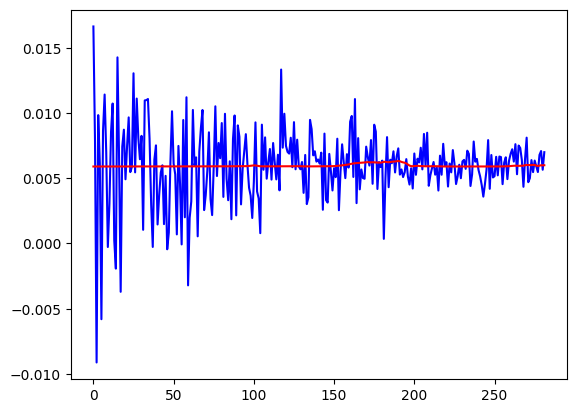

In [26]:
plt.plot(
    (-airs_signal[0][80].sum(axis=1) + airs_signal[0][0].sum(axis=1))
    / airs_signal[0][0].sum(axis=1),
    color="blue",
)
plt.plot(train_gt[train_gt.planet_id == 100468857].values[0][:1:-1], color="red")
plt.show()

In [27]:
# note that we cannot preserve mask
np.save("airs_processed.npy", airs_signal.filled())
np.save("fgs1_processed.npy", fgs1_signal.filled())

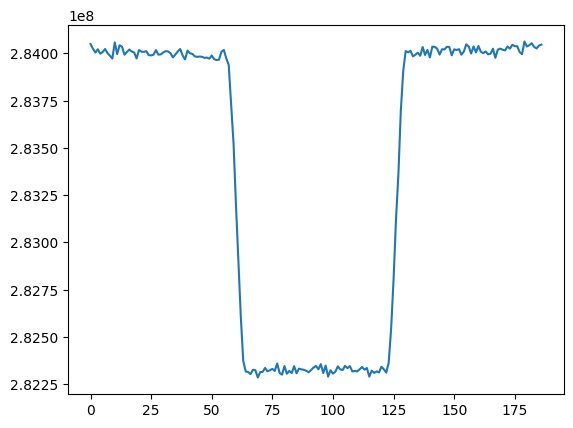

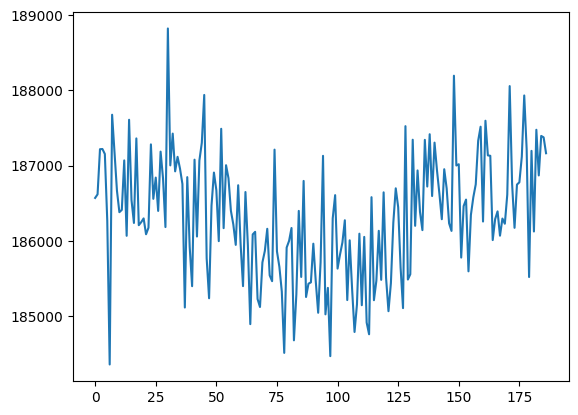

In [28]:
plt.plot(airs_signal[0].sum(axis=(1, 2)))  # white curve
plt.show()

plt.plot(airs_signal[0][:, 10, :].sum(axis=(1)))  # light curve at selected frequency
plt.show()

(187,)
(187,)


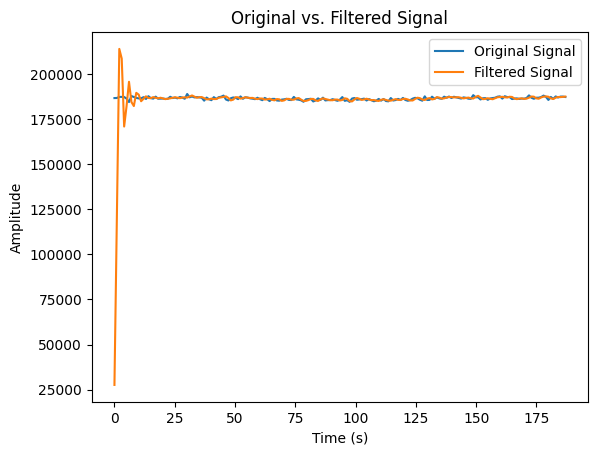

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

test_signal = airs_signal[0][:, 10, :].sum(axis=(1))

# Design a low-pass filter (adjust cutoff frequency as needed)
cutoff_freq = 0.002  # Hz
sampling_rate = 1 / (7.5 * 3600 / len(test_signal))  # Hz
order = 4

b, a = butter(order, cutoff_freq, fs=sampling_rate, btype="lowpass")

# Apply the filter
filtered_signal = lfilter(b, a, test_signal)
print(filtered_signal.shape)
print(test_signal.shape)

time = np.linspace(0, 187, 1 * 187)

# Plot the original and filtered signals
plt.plot(time, test_signal, label="Original Signal")
plt.plot(time, filtered_signal, label="Filtered Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Original vs. Filtered Signal")
plt.show()

In [30]:
# separate signals into in-transit (obs) and out of transit (unobs)
obs = airs_signal[0][70:110]
unobs = np.concatenate([airs_signal[0][0:50], airs_signal[0][140:]], axis=0)

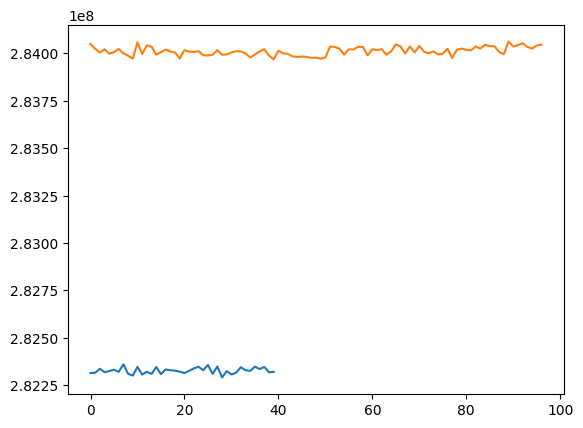

In [31]:
# plot light curve for obs and unobs, check if there are overall intensity differences
plt.plot(obs.sum(axis=(1, 2)))
plt.plot(unobs.sum(axis=(1, 2)))
plt.show()

# we see that there are fluctuations in total intensity. this could indicate that 1) starlight is oscillating; 2) device noise; 3) pointing error (which means the light
# is not projected in the middle)

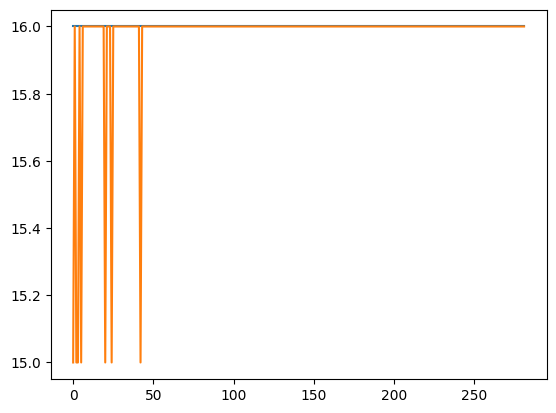

In [32]:
# check for error source 3), how much is the peak intensity of each frequency shifting wrt to the y-axis of the detector?
plt.plot(np.max(np.argmax(obs, axis=2), axis=0))
plt.plot(np.min(np.argmax(obs, axis=2), axis=0))
plt.show()

# peak intenity shifts appear only in the lower wavelengths. this likely means that the source is not actually shifting much in the y-axis,
# and so it should be safe to take the sum over the y-axis

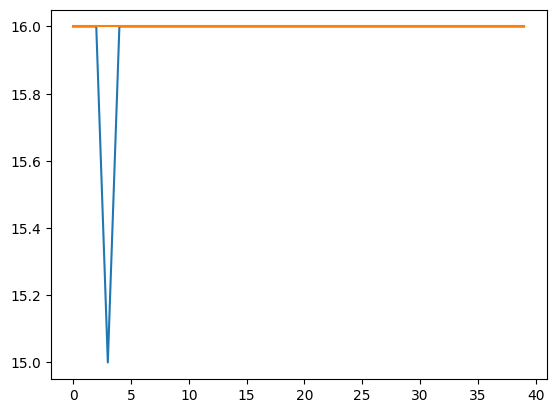

In [33]:
# check for error source 3), how much is the peak intensity of each frequency shifting wrt to the y-axis of the detector?
plt.plot(np.argmax(obs[:, :2, :], axis=2))
# plt.plot(np.min(np.argmax(obs, axis=2), axis=0))
plt.show()

# peak intenity shifts appear only in the lower wavelengths. this likely means that the source is not actually shifting much in the y-axis,
# and so it should be safe to take the sum over the y-axis

In [34]:
# # plot intensity against y-axis for lower wavelength lights - we expect to see a slight shift in the head of the distribution
# for i in range(len(unobs[0])):
#     plt.plot(obs[:, i, :].max(axis=(0)))
# plt.show()

# # we DONT see the shift as we exepct (check). the light intensity falls off beyond 5 and 25

In [35]:
# # plot intensity against y-axis for lower wavelength lights - we expect to see a slight shift in the head of the distribution
# for i in range(len(obs[0])):  # len(obs[0])
#     plt.plot(obs[:, i, :].sum(axis=(0)))
# # plt.plot(obs[:,0,14:17])
# plt.show()

# we DONT see the shift as we exepct (check). the light intensity falls off beyond 5 and 25

In [36]:
# # plot the intensity over time by neighbouring wavelengths

# for group in range(1, 10):
#     for i in range((group - 1) * 20, group * 20):
#         plt.plot(obs[:, i, 5:25].sum(axis=1))
#         plt.title(f"wavelength range: {(group-1)*20} to {group*20}")
#     plt.show()

In [37]:
# # plot the intensity over time by neighbouring wavelengths

# for group in range(1, 10):
#     for i in range((group - 1) * 20, group * 20):
#         plt.plot(unobs[:, i, 5:25].sum(axis=1))
#         plt.title(f"wavelength range: {(group-1)*20} to {group*20}")
#     plt.show()

ValueError: 'y1' is not 1-dimensional

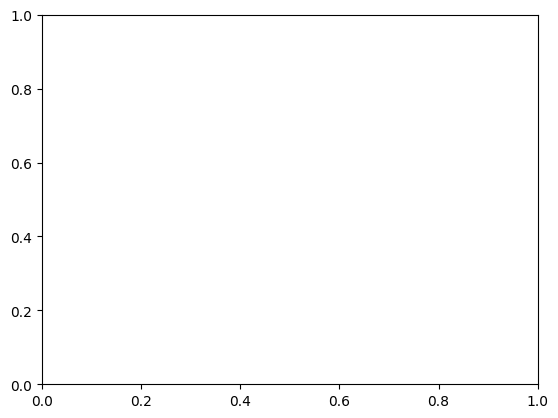

In [38]:
# Assuming your data is in a NumPy array named 'data'
# Replace with your actual data
data = obs

# Calculate minimum, maximum, and median along the desired dimension (e.g., dimension 282)
min_values = data.min(axis=(0))  # , 2))
max_values = data.max(axis=(0))  # , 2))
# median_values = np.median(data, axis=(0, 2))
median_values = np.mean(data, axis=(0))  # , 2))

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the shaded area between minimum and maximum
ax.fill_between(range(282), min_values, max_values, alpha=0.2, color="gray")

# Plot the median line
ax.plot(range(282), median_values, color="blue")

# Add labels and title
ax.set_xlabel("Dimension 282")
ax.set_ylabel("Value")
ax.set_title("Fluctuation Along Dimension 282")

plt.show()

/opt/miniconda3/envs/KaggleAriel/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4809: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


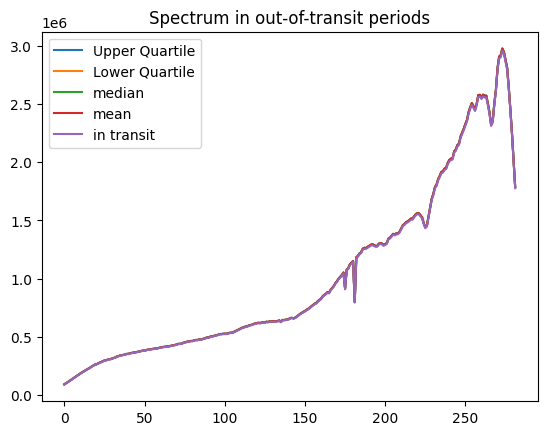

In [38]:
plt.plot(np.quantile(unobs.sum(axis=2), 0.75, axis=(0)), label="Upper Quartile")
plt.plot(np.quantile(unobs.sum(axis=2), 0.25, axis=(0)), label="Lower Quartile")
plt.plot(np.quantile(unobs.sum(axis=2), 0.5, axis=(0)), label="median")
plt.plot(unobs.sum(axis=2).mean(axis=(0)), label="mean")
plt.plot(obs.sum(axis=2).mean(axis=(0)), label="in transit")
plt.title("Spectrum in out-of-transit periods")
plt.legend()
plt.show()

In [40]:
import numpy as np
from scipy.ndimage import convolve


def smooth_2d(data):
    # Define a 3x3 averaging kernel
    kernel = np.array([1, 1, 1, 1, 1, 1, 1]) / 7

    # Apply the convolution to smooth the data
    smoothed_data = convolve(data, kernel, mode="reflect")

    return smoothed_data

In [34]:
obs_2 = np.mean(np.sum(obs[:, :, 10:20], axis=2), axis=(0))  # , 2))
unobs_2 = np.mean(np.sum(unobs[:, :, 10:20], axis=2), axis=(0))  # , 2))
series = (unobs_2 - obs_2) / unobs_2

from scipy.signal import savgol_filter

window_size = 31  # Must be an odd number
poly_order = 4  # Polynomial order for the filter
smoothed_series = savgol_filter(series, window_size, poly_order)

In [48]:
np.concatenate([airs_signal[0][0:50], airs_signal[0][140:]], axis=0).shape

(97, 282, 32)

In [42]:
factor = (
    unobs[:, :100, :].sum(axis=(1, 2)).mean() - obs[:, :100, :].sum(axis=(1, 2)).mean()
) / unobs[:, :100, :].sum(axis=(1, 2)).mean()

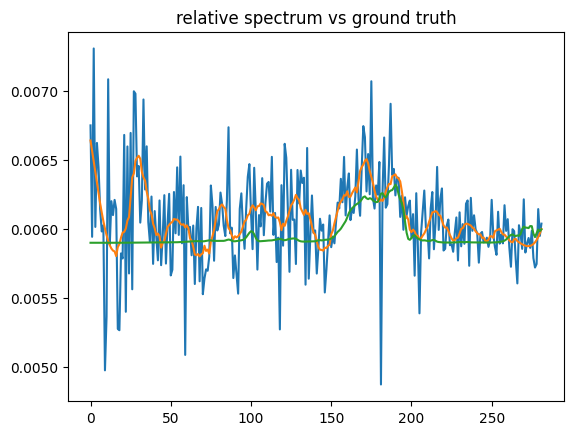

In [37]:
series = (unobs_2 - obs_2) / unobs_2

plt.title("relative spectrum vs ground truth")
plt.plot(series)
plt.plot(smoothed_series)
# plt.plot([factor] * 280)
plt.plot(train_gt[train_gt.planet_id == star_id].values[0][:1:-1])
plt.show()

In [39]:
np.mean(train_gt[train_gt.planet_id == star_id].values[0][:1:-1])

np.float64(0.005959637994567843)

(282,)

In [38]:
planet_gt = pd.DataFrame(train_gt[train_gt.planet_id == star_id].values[0][:1:-1]).T
naive_mean = np.mean(train_gt.values[:, 1:])  # train_gt.mean().mean()
naive_sigma = np.std(train_gt.values[:, 1:])  # planet_gt.std(axis=1).values

planet_sub = pd.DataFrame(np.hstack((series, np.array([0.001] * 282)))).T
print(scores(planet_gt, planet_sub, "", naive_mean, naive_sigma, 10**-5))

dummy_gt = train_gt[train_gt.planet_id == star_id].values[0][:1:-1]
planet_sub = pd.DataFrame(np.hstack((dummy_gt, np.array([10**-5] * 282)))).T
print(scores(planet_gt, planet_sub, "", naive_mean, naive_sigma, 10**-5))

planet_sub = pd.DataFrame(np.hstack((smoothed_series, np.array([0.001] * 282)))).T
print(scores(planet_gt, planet_sub, "", naive_mean, naive_sigma, 10**-5))


planet_sub = pd.DataFrame(np.hstack((np.array([s] * 282), np.array([0.001] * 282)))).T
print(scores(planet_gt, planet_sub, "", naive_mean, naive_sigma, 10**-5))

0.34333294645591256
1.0
0.3491326303577121


NameError: name 's' is not defined

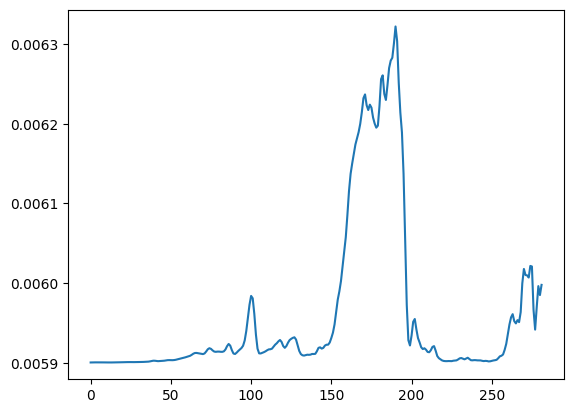

In [46]:
plt.plot(train_gt[train_gt.planet_id == star_id].values[0][:1:-1])

In [39]:
# toy model


def phase_detector(signal):
    phase1, phase2 = None, None
    best_drop = 0
    for i in range(50 // 2, 150 // 2):
        t1 = signal[i : i + 20 // 2].max() - signal[i : i + 20 // 2].min()
        if t1 > best_drop:
            phase1 = i + (20 + 5) // 2
            best_drop = t1

    best_drop = 0
    for i in range(200 // 2, 250 // 2):
        t1 = signal[i : i + 20 // 2].max() - signal[i : i + 20 // 2].min()
        if t1 > best_drop:
            phase2 = i - 5 // 2
            best_drop = t1

    return phase1, phase2


def try_s(signal, p1, p2, deg, s):
    out = list(range(p1 - 30)) + list(range(p2 + 30, signal.shape[0]))
    x, y = out, signal[out].tolist()
    x = x + list(range(p1, p2))

    y = y + (signal[p1:p2] * (1 + s[0])).tolist()
    z = np.polyfit(x, y, deg)
    p = np.poly1d(z)
    q = np.abs(p(x) - y).mean()

    if s < 1e-4:
        return q + 1e3

    return q


def calibrate_signal(signal):
    p1, p2 = phase_detector(signal)

    best_deg, best_score = 1, 1e12
    for deg in range(1, 6):
        f = partial(try_s, signal, p1, p2, deg)
        r = minimize(f, [0.001], method="Nelder-Mead")
        s = r.x[0]

        out = list(range(p1 - 30)) + list(range(p2 + 30, signal.shape[0]))
        x, y = out, signal[out].tolist()
        x = x + list(range(p1, p2))
        y = y + (signal[p1:p2] * (1 / (1 - s))).tolist()

        z = np.polyfit(x, y, deg)
        p = np.poly1d(z)
        q = np.abs(p(x) - y).mean()

        if q < best_score:
            best_score = q
            best_deg = deg
            best_s = s

        print(deg, q)
    y = y[: len(out)] + (signal[p1:p2] * (1 + best_s)).tolist()
    z = np.polyfit(x, y, best_deg)
    p = np.poly1d(z)

    return s, x, y, p(x)


def calibrate_train(signal):
    p1, p2 = phase_detector(signal)

    best_deg, best_score = 1, 1e12
    for deg in range(1, 6):
        f = partial(try_s, signal, p1, p2, deg)
        r = minimize(f, [0.0001], method="Nelder-Mead")
        s = r.x[0]

        out = list(range(p1 - 30)) + list(range(p2 + 30, signal.shape[0]))
        x, y = out, signal[out].tolist()
        x = x + list(range(p1, p2))
        y = y + (signal[p1:p2] * (1 + s)).tolist()

        z = np.polyfit(x, y, deg)
        p = np.poly1d(z)
        q = np.abs(p(x) - y).mean()

        if q < best_score:
            best_score = q
            best_deg = deg

    z = np.polyfit(x, y, best_deg)
    p = np.poly1d(z)

    return s, p(np.arange(signal.shape[0])), p1, p2

1 1.662796513597684
2 1.5059737695378639
3 1.5030376112357715
4 1.4703102414714808
5 1.4694562537181302


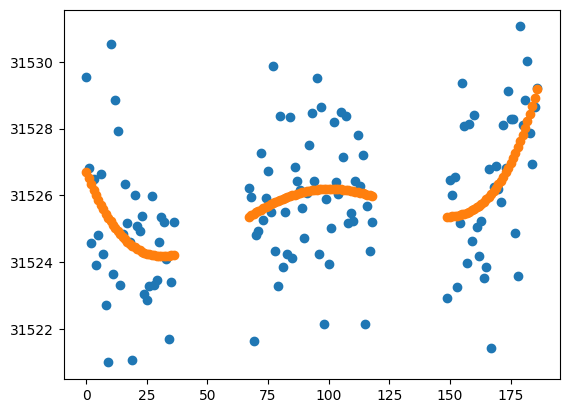

In [40]:
s, x, y, y_new = calibrate_signal(airs_signal[0].mean(axis=(1, 2)))
plt.scatter(x, y)
plt.scatter(x, y_new)

In [49]:
star_1_id = train_adc[train_adc.star == 1].planet_id
star_0_id = train_adc[train_adc.star == 0].planet_id

In [50]:
# plt.plot(train_gt[train_gt.planet_id.isin(star_1_id.values)].mean(0)[1::])
# plt.title('Ground Truth for Star Type 1')

In [51]:
# plt.plot(train_gt[train_gt.planet_id.isin(star_0_id.values)].mean(0)[1::])
# plt.title('Ground Truth for Star Type 0')

In [52]:
sigma_true = 10 / (10**6)

In [53]:
train_avg = np.insert(
    airs_signal[0].mean(axis=(0, 2)), 0, fgs1_signal[0].mean(axis=(0, 1, 2))
)
train_std = np.insert(
    airs_signal[0].std(axis=(0, 2)), 0, fgs1_signal[0].std(axis=(0, 1, 2))
)

In [54]:
new_sub = np.clip(
    np.insert((unobs_2 - obs_2) / unobs_2, 0, 0.006), a_min=0, a_max=10**6
)

In [55]:
pred = pd.DataFrame(np.concatenate([np.repeat(s, 283), np.repeat(0.000176, 283)])).T

pred = pd.DataFrame(np.concatenate([new_sub, np.repeat(0.000176, 283)])).T

In [56]:
truth = pd.DataFrame(train_gt[train_gt.planet_id == 100468857].values[0, 1:]).T

In [57]:
# frames = []
# step = 100  # Frame every 10k rows

# for i in range(0, airs_raw.shape[0]//2, step):
#     # Calculate the mean image up to the current row
#     # mean_image = fgs1_raw[:i+1].mean(axis=0)
#     mean_image = airs_raw[2*i+1]
#     # Plot the mean image
#     plt.imshow(mean_image)  # Adjust cmap based on your preference
#     plt.axis('off')  # Hide axes
#     # plt.show()
#     # Save the current frame as an image in memory
#     plt.savefig('airs.png', bbox_inches='tight')
#     plt.close()

#     # Read the saved image and append to frames list
#     frames.append(imageio.imread('airs.png'))

# # Save the frames as a GIF
# # fps controls the speed of the GIF
# imageio.mimsave('airs.gif', frames, fps=10)

# print("GIF created successfully!")


# # Example: Assuming fgs1_raw is a numpy array of shape (135000, height, width)
# frames = []
# step = 1000  # Frame every 10k rows

# for i in range(0, fgs1_raw.shape[0], step):
#     # Calculate the mean image up to the current row
#     # mean_image = fgs1_raw[:i+1].mean(axis=0)
#     mean_image = fgs1_raw[i]
#     # Plot the mean image
#     plt.imshow(mean_image, cmap='gray')  # Adjust cmap based on your preference
#     plt.axis('off')  # Hide axes

#     # Save the current frame as an image in memory
#     plt.savefig('frame.png', bbox_inches='tight')
#     plt.close()

#     # Read the saved image and append to frames list
#     frames.append(imageio.imread('frame.png'))

# # Save the frames as a GIF
# # fps controls the speed of the GIF
# imageio.mimsave('fgs1_mean.gif', frames, fps=10)

# print("GIF created successfully!")

In [58]:
scores(truth[::-1], pred, "planet_id", train_avg, train_std, sigma_true)

NameError: name 'scores' is not defined

In [36]:
import numpy as np
import pandas as pd
import pandas.api.types
import scipy.stats


class ParticipantVisibleError(Exception):
    pass


def scores(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    row_id_column_name: str,
    naive_mean: float,
    naive_sigma: float,
    sigma_true: float,
) -> float:
    """
    This is a Gaussian Log Likelihood based metric. For a submission, which contains the predicted mean (x_hat) and variance (x_hat_std),
    we calculate the Gaussian Log-likelihood (GLL) value to the provided ground truth (x). We treat each pair of x_hat,
    x_hat_std as a 1D gaussian, meaning there will be 283 1D gaussian distributions, hence 283 values for each test spectrum,
    the GLL value for one spectrum is the sum of all of them.

    Inputs:
        - solution: Ground Truth spectra (from test set)
            - shape: (nsamples, n_wavelengths)
        - submission: Predicted spectra and errors (from participants)
            - shape: (nsamples, n_wavelengths*2)
        naive_mean: (float) mean from the train set.
        naive_sigma: (float) standard deviation from the train set.
        sigma_true: (float) essentially sets the scale of the outputs.
    """

    # del solution[row_id_column_name]
    # del submission[row_id_column_name]

    if submission.min().min() < 0:
        raise ParticipantVisibleError("Negative values in the submission")
    for col in submission.columns:
        if not pandas.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f"Submission column {col} must be a number")

    n_wavelengths = len(solution.columns)
    # print()
    if len(submission.columns) != n_wavelengths * 2:
        raise ParticipantVisibleError("Wrong number of columns in the submission")

    y_pred = submission.iloc[:, :n_wavelengths].values
    # Set a non-zero minimum sigma pred to prevent division by zero errors.
    sigma_pred = np.clip(
        submission.iloc[:, n_wavelengths:].values, a_min=10**-15, a_max=None
    )
    y_true = solution.values

    GLL_pred = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_pred, scale=sigma_pred))
    GLL_true = np.sum(
        scipy.stats.norm.logpdf(
            y_true, loc=y_true, scale=sigma_true * np.ones_like(y_true)
        )
    )
    GLL_mean = np.sum(
        scipy.stats.norm.logpdf(
            y_true,
            loc=naive_mean * np.ones_like(y_true),
            scale=naive_sigma * np.ones_like(y_true),
        )
    )

    submit_score = (GLL_pred - GLL_mean) / (GLL_true - GLL_mean)
    return float(np.clip(submit_score, 0.0, 1.0))

In [41]:
np.load("../data/processed/100468857_airs.npy")

ValueError: cannot reshape array of size 0 into shape (1,187,282,32)